# 5.1 AB test

Эксперимент проходил с 2023-03-02 по 2023-03-08 включительно. Для эксперимента были задействованы 2 и 1 группы. В группе 2 был использован один из новых алгоритмов рекомендации постов, группа 1 использовалась в качестве контроля. Основная гипотеза заключается в том, что новый алгоритм во 2-й группе приведет к увеличению CTR. 

**Задача** — проанализировать данные АB-теста

* Выбрать метод анализа и сравнить CTR в двух группах (мы разбирали t-тест, Пуассоновский бутстреп, тест Манна-Уитни, t-тест на сглаженном ctr (α=5) а также t-тест и тест Манна-Уитни поверх бакетного преобразования).
* Сравнить данные этими тестами. А еще посмотреть на распределения глазами. Почему тесты сработали так как сработали? 
* Описать потенциальную ситуацию, когда такое изменение могло произойти. 
* Написать рекомендацию, стоит ли раскатывать новый алгоритм на всех новых пользователей или нет.

## Загрузка данных

In [1]:
import pandas as pd
import pandahouse as ph
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

In [2]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'database':'simulator_20230320',
    'user':'student', 
    'password':'dpo_python_2020'
}

query = '''
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2023-03-02' and '2023-03-08'
    and exp_group in (1,2)
GROUP BY exp_group, user_id
'''
df = ph.read_clickhouse(query, connection=connection)

In [3]:
# просмотр данных
df.head()

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575
3,1,26295,33,122,0.270492
4,1,18392,7,32,0.218750


In [4]:
# краткая информация о данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20031 entries, 0 to 20030
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   exp_group  20031 non-null  int8   
 1   user_id    20031 non-null  uint32 
 2   likes      20031 non-null  uint64 
 3   views      20031 non-null  uint64 
 4   ctr        20031 non-null  float64
dtypes: float64(1), int8(1), uint32(1), uint64(2)
memory usage: 567.4 KB


In [5]:
# количетство пользователей в группах
df.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
1,10079,10079,10079,10079
2,9952,9952,9952,9952


Количество пользователей в группе 1 = 10 079 чел., в группе 2 = 9 952 чел.

In [6]:
# средний CTR для каждой группы
df.groupby('exp_group').ctr.mean().reset_index()

,exp_group,ctr
0,1,0.215605
1,2,0.214419


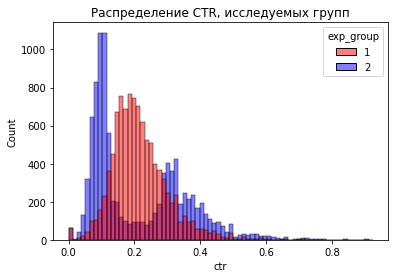

In [7]:
# распределение CTR на гистограмме
sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group',
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)\
   .set(title = 'Распределение CTR, исследуемых групп');

На графике видно, что распределение CTR первой группы выглядит нормальным, однако во второй группе присутствует обвал на месте пика первой группы, график второй групы не является нормальным распределением

## Применение теста Манна-Уитни

In [8]:
# проведение теста в Jupyter Notebook
stats.mannwhitneyu(df[df.exp_group == 1].ctr,
                df[df.exp_group == 2].ctr,
                 alternative = 'two-sided')

MannwhitneyuResult(statistic=56601260.5, pvalue=6.0376484617779035e-56)

По результатам применения теста  значение pvalue близко к 0 - группы отличны между собой

In [9]:
# проведение теста Манна-Уитни в ClickHouse
query = """
WITH mannWhitneyUTest(ctr, exp_index) as mw

SELECT 
    tupleElement(mw,1) AS statistic,
    tupleElement(mw,2) AS p_value
FROM (
    SELECT 
        exp_group,
        CASE WHEN exp_group = 1 THEN 0 ELSE 1 END AS exp_index,
        user_id,
        SUM(action = 'like') AS likes,
        SUM(action = 'view') AS views,
        likes / views AS ctr
    FROM simulator_20230320.feed_actions
    WHERE toDate(time) BETWEEN '2023-03-02' and '2023-03-08'
      AND exp_group in (1, 2)
    GROUP BY user_id, exp_group
)
"""
ph.read_clickhouse(query, connection=connection)

,statistic,p_value
0,56601260.5,1.655343e-13


При примении теста Манна-Уитни в ClickHouse значение статистики осталось таким же, а значение p-value изменилось, однако оно также довольно близко к 0, что означает отличие данных выборок между собой

## Сглаживание CTR

In [10]:
# создание функции для расчета сглаженного CTR
def get_smoothed_ctr(users_likes, users_views, global_ctr, alpha):
    smoothed_ctr = (users_likes + alpha * global_ctr) / (users_views + alpha)
    return smoothed_ctr

In [11]:
# посчет глобальных CTR для каждой групп
global_ctr_1 = df[df.exp_group == 1].likes.sum() / df[df.exp_group == 1].views.sum()
global_ctr_2 = df[df.exp_group == 2].likes.sum() / df[df.exp_group == 2].views.sum()

In [12]:
# копирование данных группы 1 в отдельный датафрейм 
group_1 = df[df.exp_group == 1].copy()

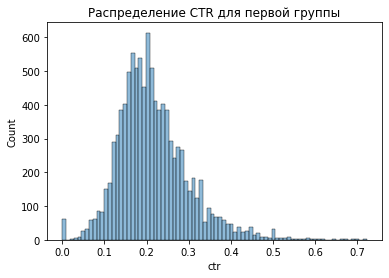

In [13]:
# построение гистограммы распределения обычного CTR для группы 1
sns.histplot(group_1.ctr, alpha=0.5, kde=False).set(title='Распределение CTR для первой группы');

In [14]:
# сглаживание CTR для первой группы 
group_1['smoothed_ctr'] = df.apply(lambda x: get_smoothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)

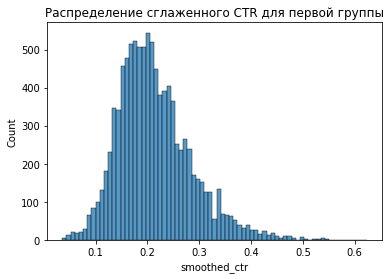

In [15]:
# построение графика сглаженного CTR для первой группы
sns.histplot(group_1.smoothed_ctr, kde = False).set(title='Распределение сглаженного CTR для первой группы');

Повторим эти же действия для второй группы

In [16]:
# копирование данных группы 2 в отдельный датафрейм 
group_2 = df[df.exp_group == 2].copy()

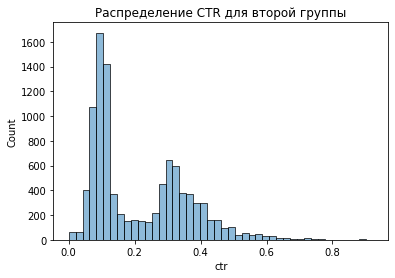

In [17]:
# построение гистограммы распределения обычного CTR для группы 2
sns.histplot(group_2.ctr, alpha=0.5, kde=False).set(title='Распределение CTR для второй группы');

In [18]:
# сглаживание CTR для второй группы 
group_2['smoothed_ctr'] = df.apply(lambda x: get_smoothed_ctr(x['likes'], x['views'], global_ctr_2, 5), axis=1)

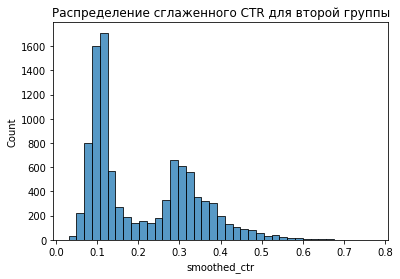

In [19]:
# построение графика сглаженного CTR для второй группы
sns.histplot(group_2.smoothed_ctr, kde = False).set(title='Распределение сглаженного CTR для второй группы');

После применения сглаживания результаты не стали более похожими на нормальное распределение.
Применим тест Манна-Уитни

In [20]:
# тест Манна-Уитни
stats.mannwhitneyu(group_1.smoothed_ctr,
                group_2.smoothed_ctr,
                 alternative = 'two-sided')

MannwhitneyuResult(statistic=56925125.0, pvalue=1.6163964114270227e-61)

In [21]:
# t-тест 
stats.ttest_ind(group_1.smoothed_ctr,
                group_2.smoothed_ctr,
                equal_var=False)

Ttest_indResult(statistic=2.2841320431616983, pvalue=0.0223769815558559)

На сглаженных данных также низкое значение pvalue, следовательно выборки различны между собой

## Пуассоновский бутстреп для подсчета разницы в CTR

In [22]:
# создание функции для расчета глобальных CTR 
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)
    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

In [23]:
# сбор необходимой для расчетов информации
likes_1 = df[df.exp_group == 1].likes.to_numpy()
views_1 = df[df.exp_group == 1].views.to_numpy()
likes_2 = df[df.exp_group == 2].likes.to_numpy()
views_2 = df[df.exp_group == 2].views.to_numpy()

In [24]:
# подсчет глобальные CTR для двух групп
ctr_1, ctr_2 = bootstrap(likes_1, views_1, likes_2, views_2)

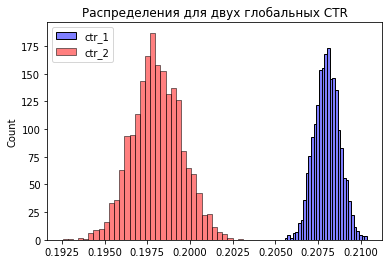

In [25]:
# построение гистограммы распределения для двух глобальных CTR
sns.histplot(ctr_1, alpha=0.5, color='b');
sns.histplot(ctr_2, alpha=0.5, color='r');
plt.legend(['ctr_1', 'ctr_2'])
plt.title('Распределения для двух глобальных CTR');

На графиках видно, что показатели глобальных CTR не пересекаются. Можно говорить о том, что в одной из групп глобальный CTR больше, чем в другой

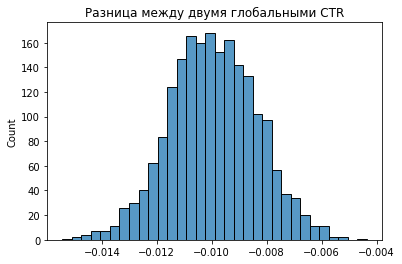

In [26]:
# разница между двумя глобальными CTR (целевая минус контрольная)
sns.histplot(ctr_2 - ctr_1);
plt.title('Разница между двумя глобальными CTR');

In [27]:
# тест Манна-Уитни
stats.mannwhitneyu(ctr_1,
                   ctr_2,
                 alternative = 'two-sided')

MannwhitneyuResult(statistic=4000000.0, pvalue=0.0)

Значение p-value=0, это подверждает, что распределения не пересекаются. В одной из групп глобальный CTR больше, чем в другой.

Разница между глобальными CTR двух групп отрицательная, следовательно контрольная группа показала себя лучше (ctr_1)

## Бакетное преобразование

In [28]:
# создаем запрос 
query = """

SELECT exp_group, bucket,
    sum(likes)/sum(views) as bucket_ctr,
    quantileExact(0.9)(ctr) as ctr9
FROM (SELECT exp_group, 
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM {db}.feed_actions 
    WHERE toDate(time) between '2023-02-23' and '2023-03-01'
        and exp_group in (1,2)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""

df_bucket = ph.read_clickhouse(query, connection=connection)

In [29]:
df_bucket.head()

,exp_group,bucket,bucket_ctr,ctr9
0,1,0,0.205796,0.320000
1,2,0,0.213679,0.333333
2,1,1,0.211543,0.306818
3,2,1,0.206881,0.336957
4,1,2,0.205496,0.296703


In [30]:
# проведение t-теста
stats.ttest_ind(df_bucket[df_bucket.exp_group == 1].bucket_ctr, 
                   df_bucket[df_bucket.exp_group == 2].bucket_ctr, 
                   equal_var = False)

Ttest_indResult(statistic=-2.249431215012112, pvalue=0.026727457897151256)

 Т-тест поверх бакетного преобразования показал pvalue < 0.05, то есть группы отличные между собой

In [31]:
# тест Манна-Уитни
stats.mannwhitneyu(df_bucket[df_bucket.exp_group == 1].bucket_ctr, 
                   df_bucket[df_bucket.exp_group == 2].bucket_ctr, 
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=950.0, pvalue=0.0389514842806052)

Результаты теста Манна-Уитни также < 0.05

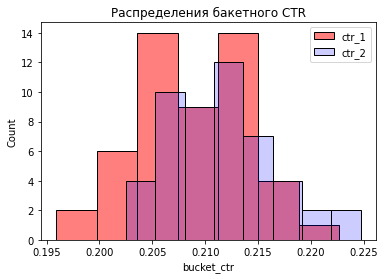

In [32]:
sns.histplot(df_bucket[df_bucket.exp_group == 1].bucket_ctr, color= 'r', alpha = 0.5);
sns.histplot(df_bucket[df_bucket.exp_group == 2].bucket_ctr, color= 'b', alpha = 0.2);
plt.legend(['ctr_1', 'ctr_2'])
plt.title('Распределения бакетного CTR');

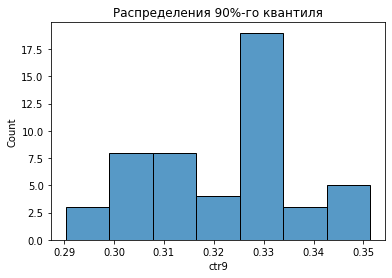

In [33]:
sns.histplot(df_bucket[df_bucket.exp_group == 2].ctr9);
plt.title('Распределения 90%-го квантиля');

Распределение не похож на нормальное

## Вывод

Таким образом, по результатам тестов можно сделать вывод о разнице CTR между контрольной и экспериментальной группами.

Распределение CTR контрольной группы нормальное, а для эксперементальной группы имеет 2 вершины (ненормальное распределение). 

Данные контрольной группы показали лучший результат. Это может быть связано с проведением рекламных кампаний, изменяющих поведение рекомендаций пользователей, также возможно, что информация собиратлась не верно, исказив тем самым результаты эксперимента, либо алгоритм рекомендаций имеет недоработки.

Следовательно, результат эксперимента нельзя назвать удовлетворительным и применять данный алгоритм рекомендаций на всех пользователей нецелесообразно. 